In [8]:
import numpy as np
import json
import pandas as pd
import seaborn as sns
sns.set()


import matplotlib.pyplot as plt
import os

In [9]:
project_dir="/content/drive/MyDrive/comp598-II/project"
work_dir=os.path.join(project_dir,"notebooks/DANN-WISDM/experiments")
result_dir=os.listdir(work_dir)
result_dir=[os.path.join(work_dir,d) for d in result_dir]
result_dir=[d for d in result_dir if '.ipynb' not in d]
summary_paths=[os.path.join(d,'summary.json') for d in result_dir]

In [27]:
def read_summary(path,fields):
  
  with open(path,'r') as jfile:
    d=json.load(jfile)

  subdict={f:d[f] for f in fields}
  
  df=pd.DataFrame.from_dict(subdict)

  arr=df.values.T  

  subj=d['target subj']

  return arr, subj

def stack_summaries(summary_paths):
  cols=['crossdomain source acc',
      'crossdomain target acc',
      'crossdomain domain acc',
      'indomain source acc',
      'indomain target acc',
      'indomain domain acc']
  
  data=np.zeros((6,5,1))
  subj=[]

  for path in summary_paths:
    d,s=read_summary(path,cols)
    data=np.concatenate((data,np.expand_dims(d,-1)),axis=-1)
    subj.append(s)
  
  data=data[:,:,1:]

  return data, np.array(subj)

def autolabel(rects, ax,xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        height=np.round(height,2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom',
                    )

def calculate_avg(columns,data, subj):
  avg=np.mean(data,axis=1)
  avg=avg.T

  avg_dict={columns[i]:avg[:,i] for i in range(len(columns))}
  avg_dict['subj']=subj
  avg_df=pd.DataFrame.from_dict(avg_dict)

  return avg_df

def gbar(data,ticks,g1,g2,label1,label2,title,width=0.35,figsize=(32,4)):
  series1=data[g1]
  series2=data[g2]

  ind=np.arange(len(series1))

  fig, ax = plt.subplots()
  fig.set_figheight(figsize[1])
  fig.set_figwidth(figsize[0])

  rects1 = ax.bar(ind - width/2, series1, width,label=label1,color="#3274a1")
  rects2 = ax.bar(ind + width/2, series2, width,label=label2,color='#e4842c')

  ax.set_xticks(ind)
  ax.set_xticklabels(ticks)

  autolabel(rects1,ax,'center')
  autolabel(rects2,ax,'center')


  plt.legend(loc='upper right',prop={'size':12})
  plt.ylabel("accuracy")
  plt.xlabel("subject ID")
  plt.title(title,fontsize=16)
  plt.show()

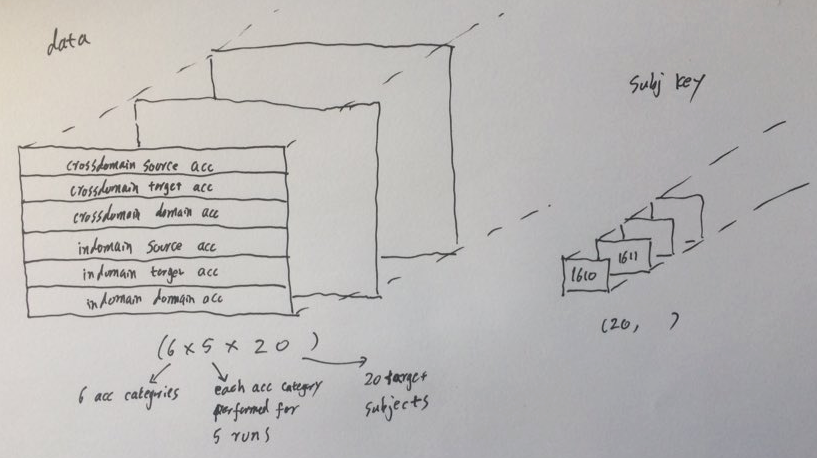

In [11]:
columns=['crossdomain source acc','crossdomain target acc','crossdomain domain acc','indomain source acc','indomain target acc','indomain domain acc']
data,subj=stack_summaries(summary_paths)
avg_df=calculate_avg(columns,data,subj)

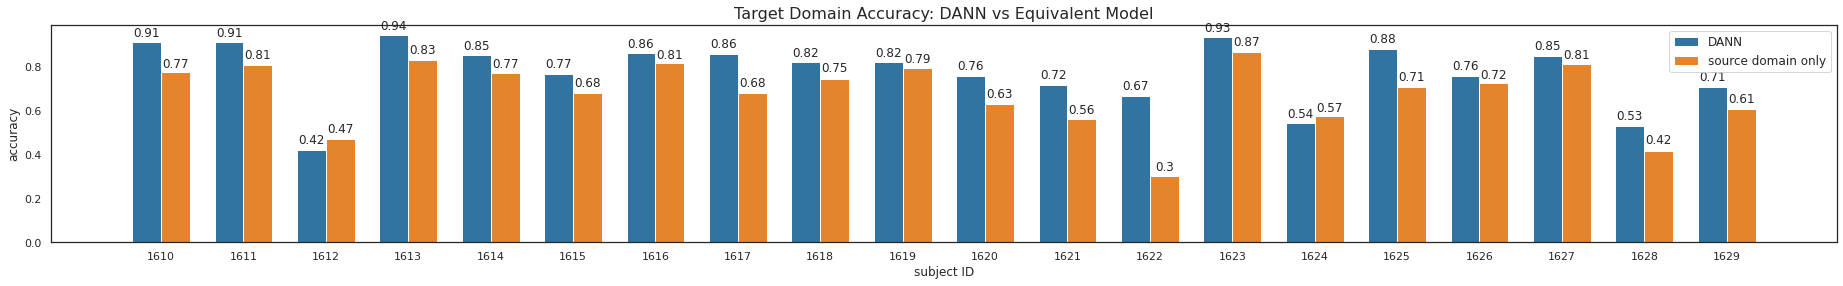

<Figure size 432x288 with 0 Axes>

In [28]:
sns.set_style("white")

gbar(avg_df,
     subj,
     'crossdomain target acc',
     'indomain target acc',
     'DANN',
     'source domain only',
     'Target Domain Accuracy: DANN vs Equivalent Model',
     )

sns.despine()

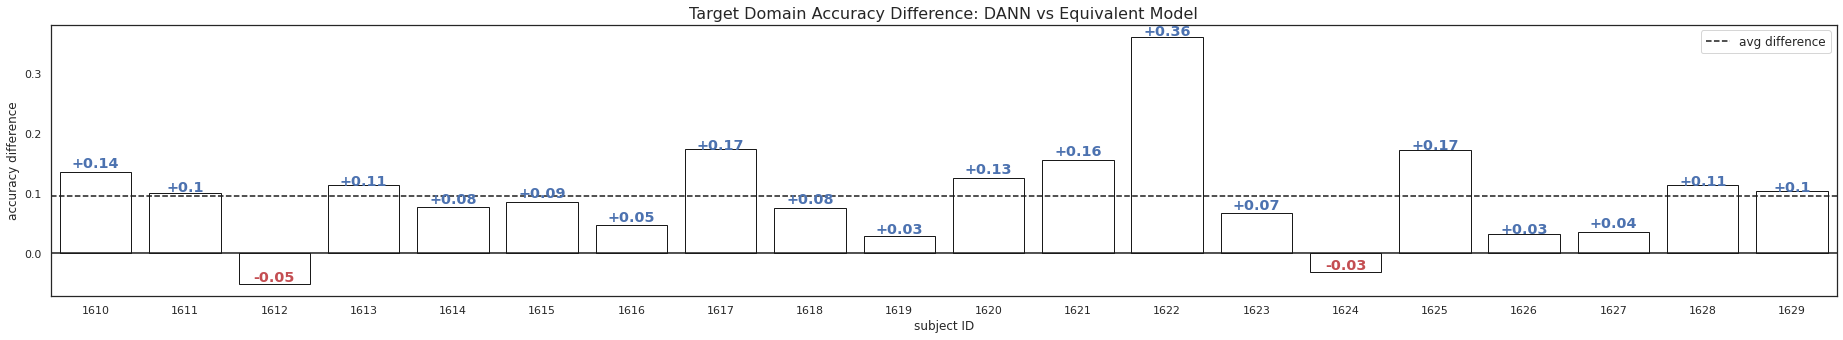

In [29]:
diff=avg_df['crossdomain target acc']-avg_df['indomain target acc']

diff_df=pd.DataFrame()
diff_df['diff']=diff
plt.figure(figsize=(32,5))
bplot=sns.barplot(data=diff_df,
                  x=subj,
                  y='diff',
                  dodge=False,
                  facecolor='w',
                  edgecolor='k'
                  )

diff_mean=diff.mean()

bplot.axhline(diff_mean,ls='--',c='k',label="avg difference")
bplot.axhline(0,c='k')

offset=0.004

for xtick in bplot.get_xticks():
  text=diff[xtick]
  text=np.round(text,2)

  s=subj[xtick]

  ypos=text+offset

  if ypos>0:
    c='b'
    text='+'+str(text)
  else:
    c='r'
  bplot.text(xtick,ypos,text,horizontalalignment='center',size='large',c=c,weight='semibold')

diff_mean=np.mean(diff)



bplot.set_title('Target Domain Accuracy Difference: DANN vs Equivalent Model',fontsize=16)

plt.legend(loc='upper right',prop={'size':12})

plt.ylabel("accuracy difference")
plt.xlabel("subject ID")
plt.show()


plt.show()

Text(0.5, 1.0, 'Target Domain Accuracy Distribution: DANN vs Equivalent Model')

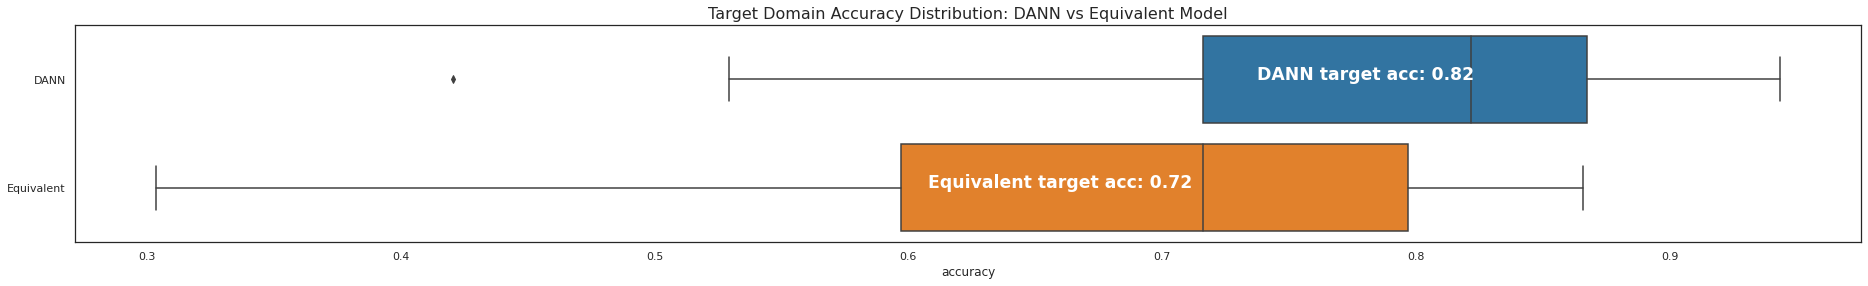

In [33]:
PROPS = {
    'boxprops':{'facecolor':'w', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

median_df=pd.DataFrame()
median_df['DANN']=avg_df['crossdomain target acc']
median_df['Equivalent'] = avg_df['indomain target acc']

plt.figure(figsize=(32,4))
bplot=sns.boxplot(y='variable',x='value',data=pd.melt(median_df),palette=sns.color_palette("tab10"))
offset=0.04

median_values=np.round(median_df.median().values,2)

text=['DANN target acc: {}'.format(median_values[0]),'Equivalent target acc: {}'.format(median_values[1])]

x1=median_values[0]
text1=text[0]

x2=median_values[1]
text2=text[1]

bplot.text(x1-0.04,0,text1,horizontalalignment='center',size='x-large',weight='semibold',color='w')
bplot.text(x2-0.06,1,text2,horizontalalignment='center',size='x-large',weight='semibold',color='w')

bplot.set(ylabel=None)

plt.xlabel('accuracy')
plt.ylabel('')
plt.title("Target Domain Accuracy Distribution: DANN vs Equivalent Model",fontsize=16)

